In [1]:
import gc
import os

import pandas as pd
from IPython.display import display
from matplotlib import pyplot as plt
from sklearn.metrics import (ConfusionMatrixDisplay, accuracy_score,
                             classification_report, confusion_matrix, f1_score)
from torch.utils.data import DataLoader
from tqdm.auto import tqdm, trange

from bert_data import *
from bert_model import *
from bert_utils import *

In [2]:
TRAIN_PATH = 'data/NLP3/train.csv'
TEST_PATH = 'data/NLP3/test.csv'

random_seed = 42

all_labels = ['World',
              'Sports',
              'Business',
              'Sci/Tech',]

os.makedirs("checkpoints", exist_ok=True)
os.makedirs("results", exist_ok=True)

In [3]:
train = pd.read_csv(TRAIN_PATH)
test = pd.read_csv(TEST_PATH)

train["text"] = train["text"].apply(preprocess_text)
train["label"] = train["label"].apply(lambda x: int(x))
test["text"] = test["text"].apply(preprocess_text)
test["label"] = test["label"].apply(lambda x: int(x))

In [4]:
val_frac = 0.1

# break train into train and validation
train = train.sample(frac=1, random_state=random_seed)
train = train.reset_index(drop=True)
train_size = int((1 - val_frac) * len(train))
train_data = train[:train_size]
val_data = train[train_size:]

In [5]:
display(train_data.head())
display(val_data.head())
display(test.head())

,index,text,label
0,1860,spammers embrace email authentication spammers...,3
1,353,ties to us and asia at stake in aussie polls s...,0
2,1333,we disclosed credit card fees say banks major ...,2
3,905,baseball win for the yankees alex rodriguez s...,1
4,1289,jo ann stores threading water sales are flat f...,2


,index,text,label
1800,1678,mobile vendors tie up for mobile tv nokia nec...,3
1801,748,loeb is on course to equal win milestone world...,1
1802,1851,apple expo apple intros imac g5 maccentral ...,3
1803,1430,the fool s look ahead the motley fool s rick m...,2
1804,484,sudan peace deal must tackle past abuses nai...,0


,index,text,label
0,0,detainees seen as minimal threat washington ...,0
1,1,japan s army works out plan to cope with north...,0
2,2,un council arrives in nairobi un security coun...,0
3,3,apec ministers urge new effort on trade talks ...,0
4,4,at least five dead in russia mine blast reute...,0


In [6]:
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')


def tokenize_and_len(sentence):
    tokens = tokenizer(sentence)
    return len(tokens['input_ids'])


In [7]:
OUTPUT_DIM = 4
SEQUENCE_LENGTH = train_data["text"].apply(lambda x: tokenize_and_len(x)).max()
print(f"{SEQUENCE_LENGTH = }")

BATCH_SIZE = 32
NUM_EPOCHS = 10
LEARNING_RATE = 1e-5
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

SEQUENCE_LENGTH = 262


In [8]:
def train(
    model,
    train_loader,
    val_loader,
    optimizer,
    scheduler,
    num_epochs,
    checkpoint_path,
    device,
):
    best_val_loss = float("inf")
    old_lr = optimizer.param_groups[0]['lr']

    for epoch in trange(num_epochs, desc='Epochs', colour='blue'):
        model.train()
        train_loss = 0
        for text, labels in tqdm(train_loader, desc='Training', colour='red'):
            optimizer.zero_grad()
            text = text.to(device)
            labels = labels.to(device)
            output = model(**text, labels=labels)
            loss = output.loss
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)
        gc.collect()

        val_loss = 0
        model.eval()
        with torch.inference_mode():
            for text, labels in tqdm(val_loader, desc='Validating', colour='magenta'):
                text = text.to(device)
                labels = labels.to(device)
                output = model(**text, labels=labels)
                loss = output.loss
                val_loss += loss.item()

        val_loss /= len(val_loader)
        gc.collect()

        scheduler.step(val_loss)
        new_lr = scheduler.get_last_lr()[0]
        print(f"Last LR: {new_lr}")

        if new_lr < old_lr:
            # load best model
            tqdm.write(
                f"Loading best model with Val Loss: {best_val_loss:.4f}\n")
            model.load_state_dict(torch.load(checkpoint_path))

        old_lr = new_lr

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            tqdm.write(f"Saving model with Val Loss: {val_loss:.4f}\n")
            torch.save(model.state_dict(), checkpoint_path)

        tqdm.write(f"Epoch {epoch + 1}/{num_epochs}, "
                   f"Train Loss: {train_loss:.4f}, "
                   f"Val Loss: {val_loss:.4f}\n\n")

    tqdm.write(f"Best Val Loss: {best_val_loss:.4f}\n")

In [9]:
def evaluate(
    model,
    test_loader,
    device,
    save_path=None,
):
    model.eval()
    pred_labels = []
    true_labels = []
    test_loss = 0
    with torch.inference_mode():
        for text, labels in tqdm(test_loader, desc='Evaluating', colour='yellow'):
            text = text.to(device)
            labels = labels.to(device)
            output = model(**text, labels=labels)
            logits = output.logits
            pred_labels.extend(logits.argmax(dim=1).tolist())
            true_labels.extend(labels.tolist())
            loss = output.loss
            test_loss += loss.item()
    gc.collect()

    test_loss /= len(test_loader)

    test_acc = accuracy_score(true_labels, pred_labels) * 100
    test_f1 = f1_score(true_labels, pred_labels, average='macro') * 100
    test_cm = confusion_matrix(true_labels, pred_labels)

    tqdm.write(f"Test Loss: {test_loss:.4f}\n")
    tqdm.write(f"Test Accuracy: {test_acc:.4f}%\n")
    tqdm.write(f"Test F1 Score: {test_f1:.4f}%\n")

    ConfusionMatrixDisplay(confusion_matrix=test_cm,
                           display_labels=all_labels) \
        .plot(values_format='d',
              cmap='Blues')
    plt.show()

    report = classification_report(true_labels, pred_labels,
                                   target_names=all_labels,
                                   output_dict=True)
    report = pd.DataFrame.from_dict(report)  # type: ignore
    display(report)

    if save_path:
        to_save = pd.read_csv(TEST_PATH)
        to_save["preds"] = pred_labels
        to_save.to_csv(save_path, index=False)

    return test_loss, test_acc, test_f1, test_cm

In [10]:
train_dataset = BERT_Dataset(train_data, "roberta-base", SEQUENCE_LENGTH)
val_dataset = BERT_Dataset(val_data, "roberta-base", SEQUENCE_LENGTH)
test_dataset = BERT_Dataset(test, "roberta-base", SEQUENCE_LENGTH)

CHECKPOINT_PATH = "checkpoints/bert_model.pth"

train_loader = DataLoader(train_dataset,
                          batch_size=BATCH_SIZE,
                          pin_memory=True,
                          shuffle=True)
val_loader = DataLoader(val_dataset,
                        batch_size=BATCH_SIZE,
                        pin_memory=True,
                        shuffle=False)
test_loader = DataLoader(test_dataset,
                         batch_size=BATCH_SIZE,
                         pin_memory=True,
                         shuffle=False)

model = BERT_Model("roberta-base", OUTPUT_DIM).to(DEVICE)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
                                                       factor=0.5, patience=2)

train(model,
      train_loader, val_loader,
      optimizer, scheduler,
      NUM_EPOCHS,
      CHECKPOINT_PATH,
      DEVICE)

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Test Loss: 0.3553

Test Accuracy: 88.8000%

Test F1 Score: 88.7141%



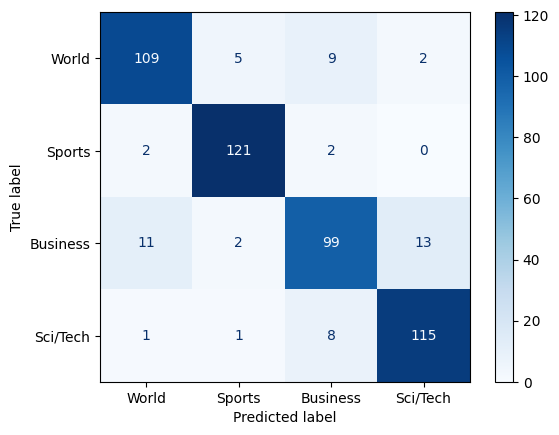

,World,Sports,Business,Sci/Tech,accuracy,macro avg,weighted avg
precision,0.886179,0.937984,0.838983,0.884615,0.888,0.886940,0.886940
recall,0.872000,0.968000,0.792000,0.920000,0.888,0.888000,0.888000
f1-score,0.879032,0.952756,0.814815,0.901961,0.888,0.887141,0.887141
support,125.000000,125.000000,125.000000,125.000000,0.888,500.000000,500.000000


In [11]:
model.load_state_dict(torch.load(CHECKPOINT_PATH))

test_loss, test_acc, test_f1, test_cm = evaluate(
    model, test_loader, DEVICE,
    save_path="results/bert_test.csv")